# Goal

Prevent a credit card fraud: when a bad actor uses someone else's credit card information to make a purchase without their permission.

**Columns**:
- **distance_from_home** - the distance from home where the transaction happened.
- **distance_from_last_transaction** - the distance from last transaction happened.
- **ratio_to_median_purchase_price** - Ratio of purchased price transaction to median purchase price.
- **repeat_retailer** - Is the transaction happened from same retailer.
- **used_chip** - Is the transaction through chip (credit card).
- **used_pin_number** - Is the transaction happened by using PIN number.
- **online_order** - Is the transaction an online order.
- **fraud** - Is the transaction fraudulent. This is what we're trying to predict.

# Imports

## libraries

In [1]:
# number crunching
import numpy as np
import pandas as pd
import scipy.stats as stats

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt

## data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

---

# Split our data

In [10]:
# features
data = train.drop(['id', 'fraud'], axis=1).copy()
data = torch.tensor(data.values).float()


In [11]:
# target
label = train.fraud.copy()
label = torch.tensor(label.values).float()
label = label[:, None] # transform to matrix (prevent error input.size)

In [12]:
# split data
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25)

# Model

## Create

In [57]:

class PCCFModelSimple(nn.Module):
    def __init__(self):
        super().__init__()

        # input
        self.input = nn.Linear(7, 20)
                
        self.h1 = nn.Linear(20,30)
        self.h2 = nn.Linear(30,20)
        self.h3 = nn.Linear(20,30)

        # output
        self.output = nn.Linear(30, 1)

    def forward(self, x):
        # input
        x = F.relu( self.input(x) )
        x = F.relu( self.h1(x) )
        x = F.relu( self.h2(x) )
        x = F.relu( self.h3(x) )

        # output
        return self.output(x)

## Training function

In [65]:
# a fixed parameter
numepochs = 5000

# Simple
def trainTheModelSimple(model):
    lossfun = nn.BCEWithLogitsLoss()
    optimizeer = torch.optim.SGD(model.parameters(), lr=.001)
    
    # initialize losses
    losses = torch.zeros(numepochs)
    train_acc = []
    test_acc = []

    for epochi in range(numepochs):
        yHat = model(X_train)

        # compute loss 
        loss = lossfun(yHat, y_train)
        losses[epochi] = loss

        # backprop
        optimizeer.zero_grad()
        loss.backward()
        optimizeer.step()

        # our own solution for calculate acc
        train_acc.append(100*torch.mean(((yHat>0) == y_train).float()).item())

        model.eval()
        with torch.no_grad():
            test_yhat = model(X_test)
        test_acc.append(100*torch.mean(((test_yhat>0)==y_test).float()).item())
        model.train()

    # final forward pass
    predictions = model(X_train)
    
    totalacc = 100*torch.mean(((predictions>.5) == y_train).float())    

    return losses,predictions,totalacc,train_acc,test_acc

## Training & Results

Final accuracy: 91.4074%


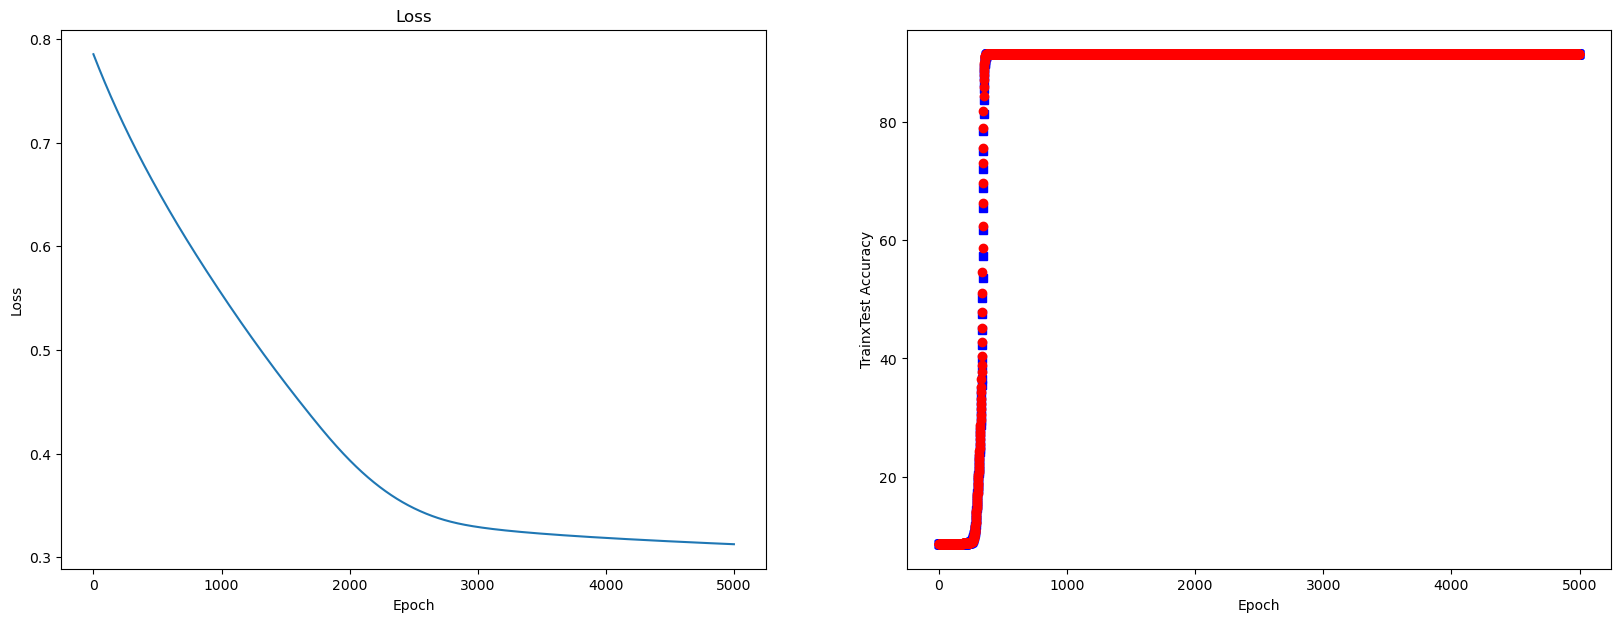

In [66]:
# Experiment with Simple data
pccf_model = PCCFModelSimple()

# training the model
losses,predictions,totalacc,train_acc,test_acc = trainTheModelSimple(pccf_model)

# plot some results
fig, ax = plt.subplots(1, 2, figsize=(20,7))

ax[0].plot(losses.detach())
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(train_acc, 'bs')
ax[1].plot(test_acc, 'ro')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('TrainxTest Accuracy')

# report accuracy
print('Final accuracy: %g%%' %totalacc)

plt.show()

## Test

In [101]:
# example of request
fake_data = pd.DataFrame([[50000.0,3.8,10000.08,.0,.0,1.0,1.0]])
fake_tensor = torch.tensor(fake_data.values).float()

with torch.no_grad():
    new_pred = pccf_model(fake_tensor)
    
# apply sigmoid function to get probabilities
probability = torch.sigmoid(new_pred)

# convert probabilities to binary labels using a threshold of 0.5
final_pred = (probability > 0.5).float()

# print the binary label
print(final_pred.item(), probability)

0.0 tensor([[0.]])


##### 

# Saving the model

In [ ]:
torch.save(pccf_model.state_dict(), 'pccf_model.pth')